In [1]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
from matplotlib.ticker import ScalarFormatter
import os



/afs/cern.ch/work/a/aradosla/private/miniforge3/lib/python3.10/site-packages/xtrack/progress_indicator.py:95: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
collider = xt.Multiline.from_json('collider/collider.json')
collider.build_trackers()

Loading line from dict: 100%|██████████| 80692/80692 [00:03<00:00, 22586.78it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 80836/80836 [00:03<00:00, 23816.00it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 80692/80692 [00:03<00:00, 23563.11it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 80836/80836 [00:03<00:00, 26708.38it/s]


Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
line = collider['lhcb1']

In [4]:
ctx = xo.ContextCpu()
N_particles = 10000
bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2 
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = collider['lhcb1'])



*** Maximum RMS bunch length 0.11789515107786017m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4969e-02
... distance to target bunch length: 8.3249e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3353e-04
... distance to target bunch length: -2.3602e-05
... distance to target bunch length: 1.8476e-07
... distance to target bunch length: -1.8173e-07
--> Bunch length: 0.0749998182688671
--> Emittance: 1.8429193446948005


In [5]:
gaussian_bunch.x

array([-2.78436350e-04,  4.07280132e-04, -1.89809072e-04, ...,
       -1.15589789e-05,  2.63162892e-04, -1.74399345e-04])

In [6]:
# Convert the bunch data to a DataFrame
# Convert the bunch data to a dictionary


pd.DataFrame(gaussian_bunch.to_dict()).to_parquet("input_particles.parquet")

gaus = pd.read_parquet('input_particles.parquet')


In [7]:
# Import the parquet gaussian bunch
N_turns = 100
#gaus = pd.read_parquet('gaussian_bunch.parquet')
#line.track(gaus,  num_turns = N_turns, turn_by_turn_monitor=True, freeze_longitudinal=True)

Text(0.5, 1.0, 'Closed orbit')

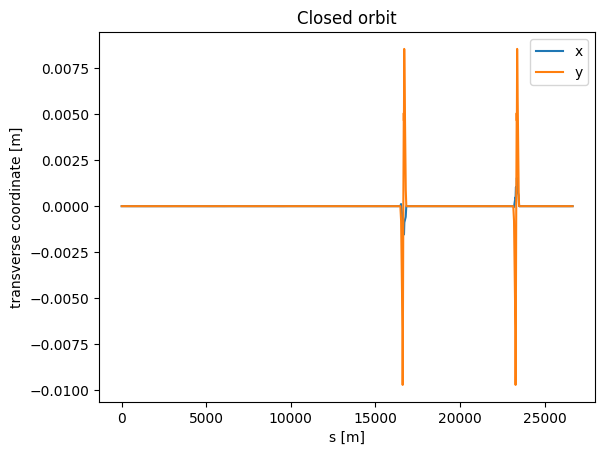

In [8]:
tw0 = collider.lhcb1.twiss()
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])

fig, ax = plt.subplots()
plt.plot(tw0.s, tw0.x, label='x')
plt.plot(tw0.s, tw0.y, label='y')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('transverse coordinate [m]')
plt.title('Closed orbit')

In [9]:

line.track(gaussian_bunch, num_turns = N_turns, turn_by_turn_monitor=True, freeze_longitudinal=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [19]:
len(gaussian_bunch.x.tolist())

10000

In [51]:
def build_particle_distribution(gaussian_bunch):
    # Define radius distribution
    #r_min = config_particles["r_min"]
    #r_max = config_particles["r_max"]
    #n_r = config_particles["n_r"]
    #radial_list = np.linspace(r_min, r_max, n_r, endpoint=False)

    # Filter out particles with low and high amplitude to accelerate simulation
    # radial_list = radial_list[(radial_list >= 4.5) & (radial_list <= 7.5)]

    # Define angle distribution
    #n_angles = config_particles["n_angles"]
    #theta_list = np.linspace(0, 90, n_angles + 2)[1:-1]

    # Define particle distribution as a cartesian product of the above
    particle_list = [
        (particle_id, y, x)
        for particle_id, (x, y) in enumerate(zip(gaussian_bunch.x, gaussian_bunch.y))
    ]
    print('first',particle_list)
    # Split distribution into several chunks for parallelization
    n_split = 2
    particle_list = np.array(np.array_split(particle_list, n_split))
    array_of_lists = np.array([arr.tolist() for arr in particle_list])
    particle_list = array_of_lists
    print('second',particle_list)

    # Return distribution
    return particle_list

def write_particle_distribution(particle_list):
    # Write distribution to parquet files
    distributions_folder = "particles"
    os.makedirs(distributions_folder, exist_ok=True)
    for idx_chunk, my_list in enumerate(particle_list):
        pd.DataFrame(
            my_list,
            columns=["particle_id", "normalized amplitude in xy-plane", "angle in xy-plane [deg]"],
        ).to_parquet(f"{distributions_folder}/{idx_chunk:02}.parquet")

In [54]:
part = build_particle_distribution(gaussian_bunch)

print('end',np.array(part))

#print(np.array(part).shape)
write_particle_distribution(part)

first [(0, -0.00022069762247946335, -0.000287123368428771), (1, 0.0002599618391824376, 0.00040043230285597797), (2, 0.00020205353730024046, -0.00015763655300280892), (3, 0.0002228159474656177, 0.00017790322547741935), (4, 0.0001801798277415959, -0.0001307268468100497), (5, -0.00034949340822491647, -0.00010217287053128896), (6, -0.00020975107516982757, 0.0002494462243137782), (7, 8.398167821355638e-05, 0.00011929106274424725), (8, 0.00015607180993672774, -0.00014088283791759257), (9, 0.00016203373589065355, -4.5330126574205654e-05), (10, -3.400447180153995e-06, -8.152960266052734e-05), (11, 0.00022953598282358424, 9.452046853705643e-05), (12, -0.00013272293424636497, 7.291003196669107e-06), (13, 0.00030608234335925, 5.2437689818069704e-05), (14, -3.0845928768450054e-05, 0.00032175544033555747), (15, -0.00034045741685314267, 8.525260118041632e-06), (16, -0.00027165118088782645, -0.00024424159907204205), (17, -0.0002450832337927724, -0.0003627948700610968), (18, 0.000231413462922792, -0.0

In [55]:
import time
def track(collider, particles, save_input_particles=False):
    # Get beam being tracked
    beam = collider['lhcb1']

    # Optimize line for tracking (not working for now)
    # collider[beam].optimize_for_tracking()

    # Save initial coordinates if requested
    if save_input_particles:
        pd.DataFrame(particles.to_dict()).to_parquet("input_particles.parquet")              # here save the initial distribution

    # Track
    num_turns = N_turns
    a = time.time()
    collider['lhcb1'].track(particles, turn_by_turn_monitor=False, num_turns=num_turns)         # tracking of the distribution 
    b = time.time()

    print(f"Elapsed time: {b-a} s")
    print(f"Elapsed time per particle per turn: {(b-a)/particles._capacity/num_turns*1e6} us")

    return particles

In [56]:
track(collider, part)

AttributeError: 'numpy.ndarray' object has no attribute 'gen_local_particle_api'

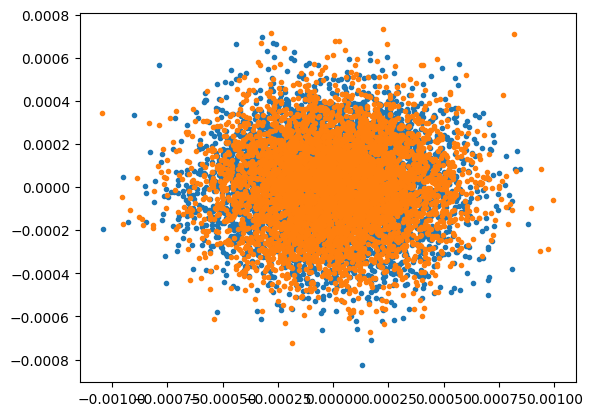

In [ ]:
plt.plot(np.array(part).T[:][1], np.array(part).T[:][2], '.')